---
# **KAGGLE Project : "Chest X-Ray Images (Pneumonia)"**
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Objectif : *detect pneumonia in chest X-ray images using a deep learning approach*

Authors :
- AUCOUTURIER Camille
- BALOCHE Valentin

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Importing necessary packages :

In [ ]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from keras.applications.inception_v3 import InceptionV3

## Loading and preparing data :

In [ ]:
# Definition of path files
path = "/content/drive/MyDrive/kaggle_project/data"
path_train = os.path.join(path, "train")
path_test = os.path.join(path, "test")

path_train_normal = glob.glob(path_train + "/NORMAL/*.jpeg")
path_train_bacterial_pneumonia = glob.glob(path_train + "/PNEUMONIA/BACTERIA*.jpeg")
path_train_viral_pneumonia = glob.glob(path_train + "/PNEUMONIA/VIRUS*.jpeg")

path_test_normal = glob.glob(path_test + "/NORMAL/*.jpeg")
path_test_bacterial_pneumonia = glob.glob(path_test + "/PNEUMONIA/BACTERIA*.jpeg")
path_test_viral_pneumonia = glob.glob(path_test + "/PNEUMONIA/VIRUS*.jpeg")

In [ ]:
# Number of files in each folder
print(f"Training normal images : {len(path_train_normal)}")
print(f"Training bacterial pneumonia images : {len(path_train_bacterial_pneumonia)}")
print(f"Training viral pneumonia images : {len(path_train_viral_pneumonia)}")
print("\n")
print(f"Testing normal images : {len(path_test_normal)}")
print(f"Testing bacterial pneumonia images : {len(path_test_bacterial_pneumonia)}")
print(f"Testing viral pneumonia images : {len(path_test_viral_pneumonia)}")

Training normal images : 1349
Training bacterial pneumonia images : 2538
Training viral pneumonia images : 1345


Testing normal images : 234
Testing bacterial pneumonia images : 242
Testing viral pneumonia images : 148


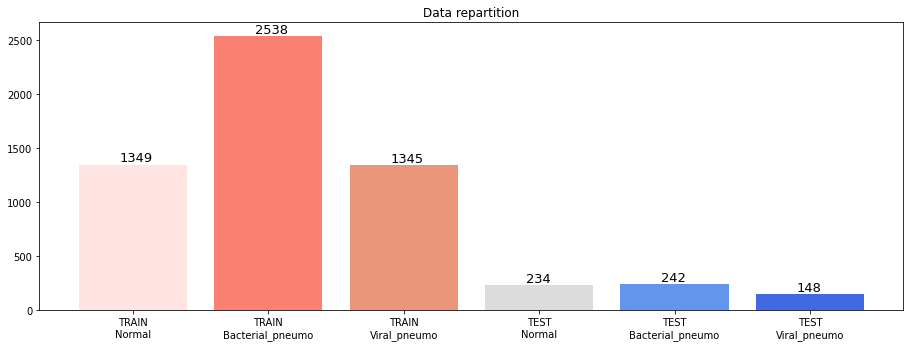

In [ ]:
# Graphic representation of dataset
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
sets = ['TRAIN\nNormal', 'TRAIN\nBacterial_pneumo', 'TRAIN\nViral_pneumo', 'TEST\nNormal', 'TEST\nBacterial_pneumo', 'TEST\nViral_pneumo']
num = [len(path_train_normal), len(path_train_bacterial_pneumonia), len(path_train_viral_pneumonia), len(path_test_normal), len(path_test_bacterial_pneumonia), len(path_test_viral_pneumonia)]
ax.bar(sets, num, color=['mistyrose', 'salmon', 'darksalmon', 'gainsboro', 'cornflowerblue', 'royalblue'])
plt.title("Data repartition")

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.3, p.get_height()+30), fontsize = 13)

plt.show()
plt.rcParams.update({'font.size': 12})

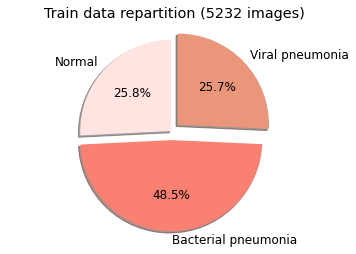

In [ ]:
# Data train repartition pie chart
total_length = len(path_train_normal) + len(path_train_bacterial_pneumonia) + len(path_train_viral_pneumonia)
labels = 'Normal', 'Bacterial pneumonia', 'Viral pneumonia'
sizes = [len(path_train_normal)/total_length, len(path_train_bacterial_pneumonia)/total_length, len(path_train_viral_pneumonia)/total_length]
explode = (0, 0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['mistyrose', 'salmon', 'darksalmon'])
ax1.axis('equal')
plt.title("Train data repartition (5232 images)", loc = 'center')

plt.show()



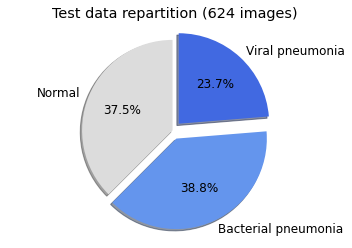

In [ ]:
# Data test repartition pie chart
total_length = len(path_test_normal) + len(path_test_bacterial_pneumonia) + len(path_test_viral_pneumonia)
labels = 'Normal', 'Bacterial pneumonia', 'Viral pneumonia'
sizes = [len(path_test_normal)/total_length, len(path_test_bacterial_pneumonia)/total_length, len(path_test_viral_pneumonia)/total_length]
explode = (0, 0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['gainsboro', 'cornflowerblue', 'royalblue'])
ax1.axis('equal')
plt.title("Test data repartition (624 images)", loc = 'center')

plt.show()

In [ ]:
# Image shapes before resizing are heterogeneous
for i in range (10):
    print(np.shape(load_img(path_train_normal[i])))

(1341, 1840, 3)
(1237, 1156, 3)
(1746, 2014, 3)
(1982, 2068, 3)
(1612, 1774, 3)
(1522, 1728, 3)
(1272, 1622, 3)
(1260, 1632, 3)
(1156, 1678, 3)
(1677, 1936, 3)


In [ ]:
# Creation of 2 validation sets (20%)
random.seed(1234)

data_val_normal = set(random.sample(path_train_normal, 270))
data_val_bacterial_pneumonia = set(random.sample(path_train_bacterial_pneumonia, 508))
data_val_viral_pneumonia = set(random.sample(path_train_viral_pneumonia, 269))

data_train_normal = set(path_train_normal) - data_val_normal
data_train_bacterial_pneumonia = set(path_train_bacterial_pneumonia) - data_val_bacterial_pneumonia
data_train_viral_pneumonia = set(path_train_viral_pneumonia) - data_val_viral_pneumonia

In [ ]:
# Loading images in list from each folder and resizing in (224, 224, 3)
img_data_train_normal = [load_img(file, target_size=(224, 224)) for file in data_train_normal]
img_data_train_bacterial_pneumonia = [load_img(file, target_size=(224,224)) for file in data_train_bacterial_pneumonia]
img_data_train_viral_pneumonia = [load_img(file, target_size=(224,224)) for file in data_train_viral_pneumonia]

img_data_val_normal = [load_img(file, target_size=(224,224)) for file in data_val_normal]
img_data_val_bacterial_pneumonia =[load_img(file, target_size=(224,224)) for file in data_val_bacterial_pneumonia]
img_data_val_viral_pneumonia = [load_img(file, target_size=(224,224)) for file in data_val_viral_pneumonia]

img_data_test_normal = [load_img(file, target_size=(224,224)) for file in path_test_normal]
img_data_test_bacterial_pneumonia = [load_img(file, target_size=(224,224)) for file in path_test_bacterial_pneumonia]
img_data_test_viral_pneumonia = [load_img(file, target_size=(224,224)) for file in path_test_viral_pneumonia]

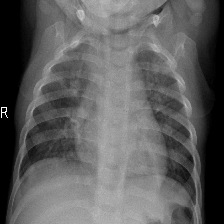

In [ ]:
# Visualizing loaded image from data test pneumonia
img_data_test_bacterial_pneumonia[11]

## **Part 1 : CNN with 2 classes --> Normal or Pneumonia**



In [ ]:
# Conversing images in pixel matrix in aray
x_2train = [img_to_array(image) for image in img_data_train_normal]
x_2train.extend([img_to_array(image) for image in img_data_train_bacterial_pneumonia])
x_2train.extend([img_to_array(image) for image in img_data_train_viral_pneumonia])
x_2train = np.asarray(x_2train)

x_2val = [img_to_array(image) for image in img_data_val_normal]
x_2val.extend([img_to_array(image) for image in img_data_val_bacterial_pneumonia])
x_2val.extend([img_to_array(image) for image in img_data_val_viral_pneumonia])
x_2val = np.asarray(x_2val)

x_2test = [img_to_array(image) for image in img_data_test_normal]
x_2test.extend([img_to_array(image) for image in img_data_test_bacterial_pneumonia])
x_2test.extend([img_to_array(image) for image in img_data_test_viral_pneumonia])
x_2test = np.asarray(x_2test)

In [ ]:
# Creating label matrix "normal" or "pneumonia"
y_2train = ["normal" for image in img_data_train_normal]
y_2train.extend(["pneumonia" for image in img_data_train_bacterial_pneumonia])
y_2train.extend(["pneumonia" for image in img_data_train_viral_pneumonia])
y_2train = np.asarray(y_2train)

y_2val = ["normal" for image in img_data_val_normal]
y_2val.extend(["pneumonia" for image in img_data_val_bacterial_pneumonia])
y_2val.extend(["pneumonia" for image in img_data_val_viral_pneumonia])
y_2val = np.asarray(y_2val)

y_2test = ["normal" for image in img_data_test_normal]
y_2test.extend(["pneumonia" for image in img_data_test_bacterial_pneumonia])
y_2test.extend(["pneumonia" for image in img_data_test_viral_pneumonia])
y_2test = np.asarray(y_2test)

In [ ]:
print(f"Type of x_2train : {type(x_2train)}")
print(f"Type of y_2train : {type(y_2train)}")

Type of x_2train : <class 'numpy.ndarray'>
Type of y_2train : <class 'numpy.ndarray'>


In [ ]:
print(f"Shape of x_2train : {x_2train.shape}")
print(f"Shape of y_2train : {y_2train.shape}")

print(f"Shape of x_2validation : {x_2val.shape}")
print(f"Shape of y_2validation : {y_2val.shape}")

Shape of x_2train : (4185, 224, 224, 3)
Shape of y_2train : (4185,)
Shape of x_2validation : (1047, 224, 224, 3)
Shape of y_2validation : (1047,)


In [ ]:
# Scaling images to the [0, 1] range in 32 bits
x_2train = x_2train.astype("float32") / 255
x_2val = x_2val.astype("float32") / 255
x_2test = x_2test.astype("float32") / 255

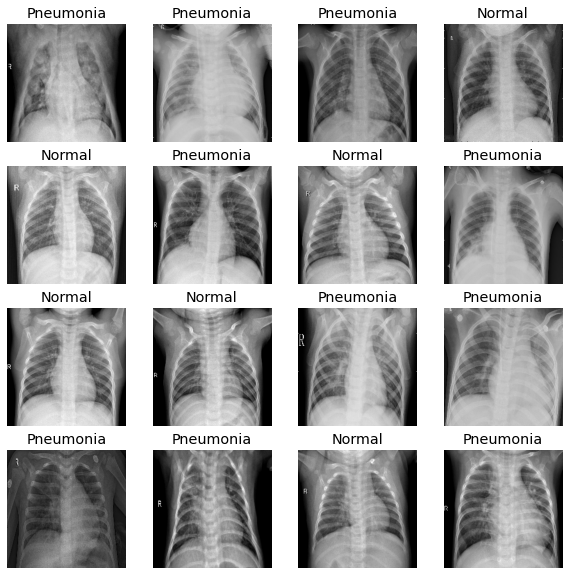

In [ ]:
# Viewing of some randomly selected images in the train folder
plt.figure(figsize=(10,10))
j = -1
for i in random.sample(range(0, len(x_2train) - 1), 16):
    j += 1
    ax=plt.subplot(4, 4, j+1)
    plt.imshow(np.squeeze(x_2train[i]), cmap=plt.get_cmap("gray"))

    if y_2train[i] == "normal" :
        plt.title("Normal")
    
    elif y_2train[i] == "pneumonia" :
        plt.title("Pneumonia")

    plt.axis("off")

plt.show() 

In [ ]:
# Converting class vector for train data
classes_2train = preprocessing.LabelEncoder()
classes_2train.fit(y_2train)
classes_2train = classes_2train.transform(y_2train)
onehot_y_2train = keras.utils.to_categorical(classes_2train, 2)

In [ ]:
# Converting class vector for validation data
classes_2val = preprocessing.LabelEncoder()
classes_2val.fit(y_2val)
classes_2val = classes_2val.transform(y_2val)
onehot_y_2val = keras.utils.to_categorical(classes_2val, 2)

In [ ]:
#Converting class vector for test data
classes_2test = preprocessing.LabelEncoder()
classes_2test.fit(y_2test)
classes_2test = classes_2test.transform(y_2test)
onehot_y_2test = keras.utils.to_categorical(classes_2test, 2)

## Building CNN model :

In [ ]:
#keras.backend.clear_session()

In [ ]:
# Define input shape
input_shape = (224, 224, 3)
num_classes = 2

In [ ]:
# Define architecture of model
input_model = layers.Input(shape=input_shape)
conv_1 = layers.Conv2D(32, kernel_size=(3,3), activation="relu")(input_model)
max_pool_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = layers.Conv2D(64, kernel_size=(3,3), activation="relu")(max_pool_1)
max_pool_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = layers.Conv2D(128, kernel_size=(3,3), activation="relu")(max_pool_2)
max_pool_3 = layers.MaxPooling2D(pool_size=(2,2))(conv_3)
flatten_1 = layers.Flatten()(max_pool_3)
drop_out_1 = layers.Dropout(0.2)(flatten_1)
output = layers.Dense(num_classes, activation="softmax")(drop_out_1)
                                 
model = keras.Model(inputs=input_model, outputs=output)

In [ ]:
# Summarize model
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0     

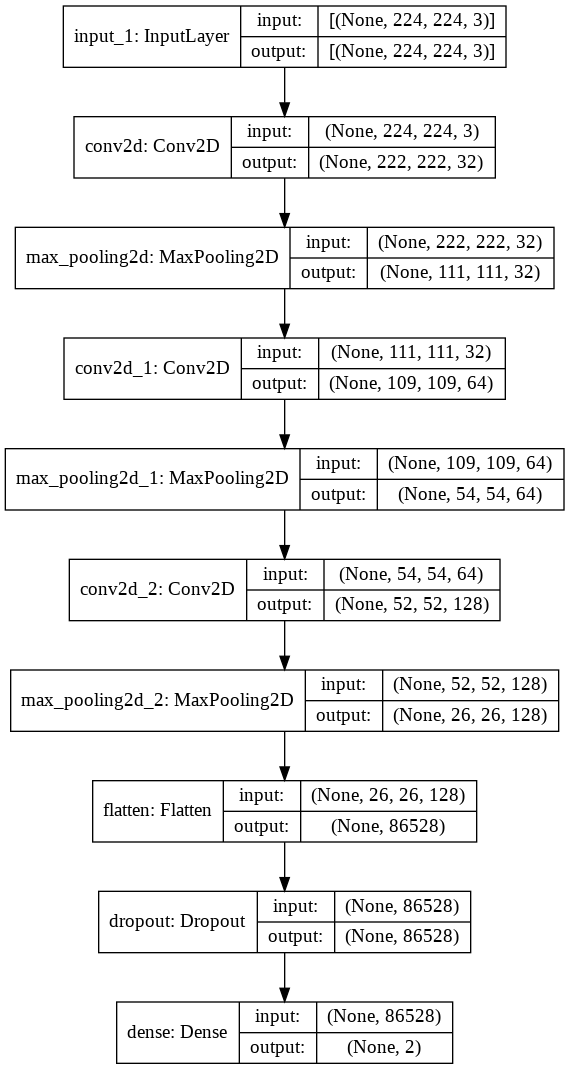

In [ ]:
keras.utils.plot_model(model, "CNN_chestXray.png", show_shapes=True)

## Trainning CNN model :

In [ ]:
batch_size = 32
epochs = 10
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
history = model.fit(x_2train, onehot_y_2train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_2val, onehot_y_2val),
                    shuffle=True)

Epoch 1/10
131/131 [==============================] - 46s 115ms/step - loss: 0.3576 - accuracy: 0.8401 - val_loss: 0.2156 - val_accuracy: 0.9160
Epoch 2/10
131/131 [==============================] - 13s 100ms/step - loss: 0.1376 - accuracy: 0.9472 - val_loss: 0.0859 - val_accuracy: 0.9733
Epoch 3/10
131/131 [==============================] - 13s 99ms/step - loss: 0.0991 - accuracy: 0.9658 - val_loss: 0.0718 - val_accuracy: 0.9828
Epoch 4/10
131/131 [==============================] - 13s 99ms/step - loss: 0.0819 - accuracy: 0.9692 - val_loss: 0.0962 - val_accuracy: 0.9599
Epoch 5/10
131/131 [==============================] - 13s 100ms/step - loss: 0.0772 - accuracy: 0.9704 - val_loss: 0.0724 - val_accuracy: 0.9704
Epoch 6/10
131/131 [==============================] - 13s 100ms/step - loss: 0.0763 - accuracy: 0.9732 - val_loss: 0.0580 - val_accuracy: 0.9799
Epoch 7/10
131/131 [==============================] - 13s 101ms/step - loss: 0.0602 - accuracy: 0.9768 - val_loss: 0.0578 - val_accu

## Evaluating CNN model :

In [ ]:
# Evaluate model with test data
_, acc = model.evaluate(x_2test, onehot_y_2test, verbose=1)
print("Accuracy = " '%.3f' % (acc * 100.0))

20/20 [==============================] - 1s 55ms/step - loss: 1.0124 - accuracy: 0.7564
Accuracy = 75.641


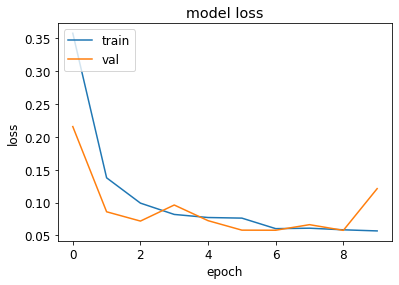

In [ ]:
# Plot history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

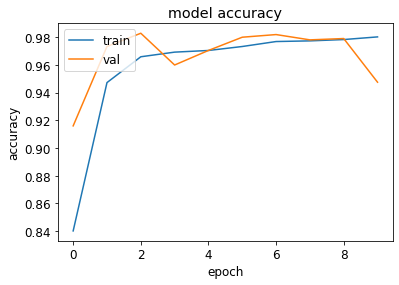

In [ ]:
# Plot history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
#plt.gca().set_ylim(0.9, 1.01)
plt.show()

In [ ]:
y_2pred = model.predict(x_2test)
y_2pred = np.argmax(y_2pred, axis=1)

y_2true = np.argmax(onehot_y_2test, axis=1)

In [ ]:
print(classification_report(y_2true, y_2pred, target_names = ['normal', 'pneumonia']))

              precision    recall  f1-score   support

      normal       1.00      0.35      0.52       234
   pneumonia       0.72      1.00      0.84       390

    accuracy                           0.76       624
   macro avg       0.86      0.68      0.68       624
weighted avg       0.82      0.76      0.72       624



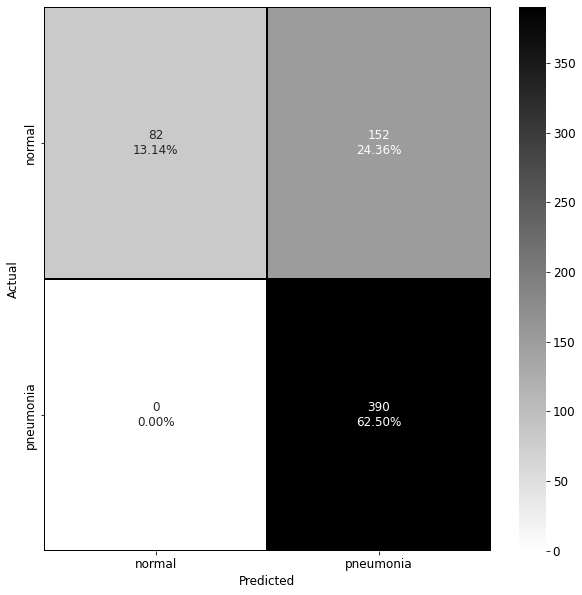

In [ ]:
cm = confusion_matrix(y_2true, y_2pred)
names = ['normal', 'pneumonia']

cm = pd.DataFrame(cm, index = names , columns = names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (10,10))
sns.heatmap(cm,
            annot=labels,
            cmap= "binary",
            linecolor = 'black',
            linewidth = 1,
            fmt='')

## **Part 2 : CNN with 3 classes --> Normal, Bacterial pneumonia or Viral pneumonia**

In [ ]:
# Converting images in pixel matrix in aray
x_3train = [img_to_array(image) for image in img_data_train_normal]
x_3train.extend([img_to_array(image) for image in img_data_train_bacterial_pneumonia])
x_3train.extend([img_to_array(image) for image in img_data_train_viral_pneumonia])
x_3train = np.asarray(x_3train)

x_3val = [img_to_array(image) for image in img_data_val_normal]
x_3val.extend([img_to_array(image) for image in img_data_val_bacterial_pneumonia])
x_3val.extend([img_to_array(image) for image in img_data_val_viral_pneumonia])
x_3val = np.asarray(x_3val)

x_3test = [img_to_array(image) for image in img_data_test_normal]
x_3test.extend([img_to_array(image) for image in img_data_test_bacterial_pneumonia])
x_3test.extend([img_to_array(image) for image in img_data_test_viral_pneumonia])
x_3test = np.asarray(x_3test)

In [ ]:
# Creating label matrix "normal" or "bacterial_pneumonia" or "viral_pneumonia"
y_3train = ["normal" for image in img_data_train_normal]
y_3train.extend(["bacterial_pneumonia" for image in img_data_train_bacterial_pneumonia])
y_3train.extend(["viral_pneumonia" for image in img_data_train_viral_pneumonia])
y_3train = np.asarray(y_3train)

y_3val = ["normal" for image in img_data_val_normal]
y_3val.extend(["bacterial_pneumonia" for image in img_data_val_bacterial_pneumonia])
y_3val.extend(["viral_pneumonia" for image in img_data_val_viral_pneumonia])
y_3val = np.asarray(y_3val)

y_3test = ["normal" for image in img_data_test_normal]
y_3test.extend(["bacterial_pneumonia" for image in img_data_test_bacterial_pneumonia])
y_3test.extend(["viral_pneumonia" for image in img_data_test_viral_pneumonia])
y_3test = np.asarray(y_3test)

In [ ]:
print(f"Type of x_3train : {type(x_3train)}")
print(f"Type of y_3train : {type(y_3train)}")

Type of x_3train : <class 'numpy.ndarray'>
Type of y_3train : <class 'numpy.ndarray'>


In [ ]:
print(f"Shape of x_3train : {x_3train.shape}")
print(f"Shape of y_3train : {y_3train.shape}")

print(f"Shape of x_3validation : {x_3val.shape}")
print(f"Shape of y_3validation : {y_3val.shape}")

Shape of x_3train : (4185, 224, 224, 3)
Shape of y_3train : (4185,)
Shape of x_3validation : (1047, 224, 224, 3)
Shape of y_3validation : (1047,)


In [ ]:
# Scaling images to the [0, 1] range in 32 bits
x_3train = x_3train.astype("float32") / 255
x_3val = x_3val.astype("float32") / 255
x_3test = x_3test.astype("float32") / 255

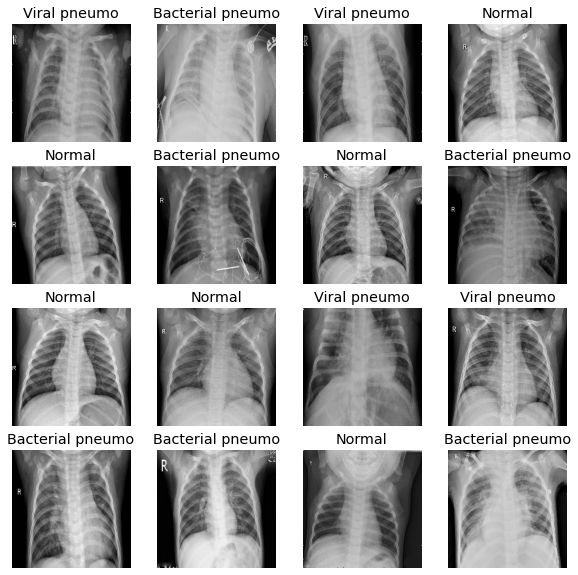

In [ ]:
# Viewing of some randomly selected images in the train folder
plt.figure(figsize=(10,10))
j = -1
for i in random.sample(range(0, len(x_3train) - 1), 16):
    j += 1
    ax=plt.subplot(4, 4, j+1)
    plt.imshow(np.squeeze(x_3train[i]), cmap=plt.get_cmap("gray"))

    if y_3train[i] == "normal" :
        plt.title("Normal")

    elif y_3train[i] == "bacterial_pneumonia" :
        plt.title("Bacterial pneumo")

    elif y_3train[i] == "viral_pneumonia" :
        plt.title("Viral pneumo")

    plt.axis("off")

plt.show()

In [ ]:
# Converting class vector for train data
classes_3train = preprocessing.LabelEncoder()
classes_3train.fit(y_3train)
classes_3train = classes_3train.transform(y_3train)
onehot_y_3train = keras.utils.to_categorical(classes_3train, 3)

In [ ]:
# Converting class vector for validation data
classes_3val = preprocessing.LabelEncoder()
classes_3val.fit(y_3val)
classes_3val = classes_3val.transform(y_3val)
onehot_y_3val = keras.utils.to_categorical(classes_3val, 3)

In [ ]:
#Converting class vector for test data
classes_3test = preprocessing.LabelEncoder()
classes_3test.fit(y_3test)
classes_3test = classes_3test.transform(y_3test)
onehot_y_3test = keras.utils.to_categorical(classes_3test, 3)

## Building CNN model :

In [ ]:
# Define input shape
input_shape = (224, 224, 3)
num_classes = 3

In [ ]:
# Define architecture of model
input_model = layers.Input(shape=input_shape)
conv_1 = layers.Conv2D(32, kernel_size=(3,3), activation="relu")(input_model)
max_pool_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = layers.Conv2D(64, kernel_size=(3,3), activation="relu")(max_pool_1)
max_pool_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = layers.Conv2D(128, kernel_size=(3,3), activation="relu")(max_pool_2)
max_pool_3 = layers.MaxPooling2D(pool_size=(2,2))(conv_3)
flatten_1 = layers.Flatten()(max_pool_3)
drop_out_1 = layers.Dropout(0.2)(flatten_1)
output = layers.Dense(num_classes, activation="softmax")(drop_out_1)
                                 
model = keras.Model(inputs=input_model, outputs=output)

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0     

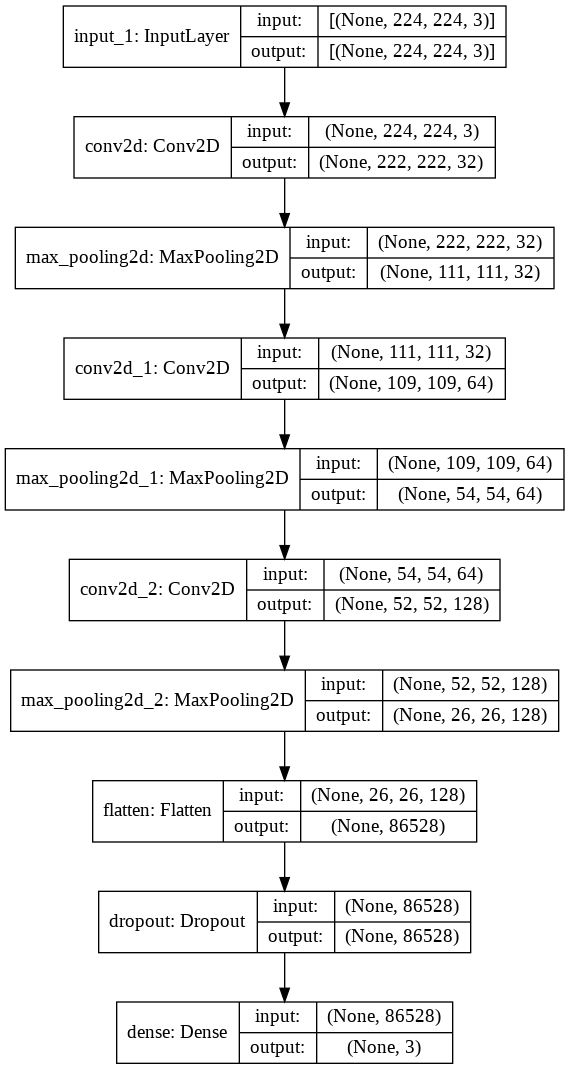

In [ ]:
keras.utils.plot_model(model, "CNN_chestXray.png", show_shapes=True)

## Trainning CNN model :

In [ ]:
batch_size = 32
epochs = 10
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
history = model.fit(x_3train, onehot_y_3train, batch_size=batch_size, epochs=epochs, validation_data=(x_3val, onehot_y_3val))

Epoch 1/10
131/131 [==============================] - 46s 116ms/step - loss: 0.8441 - accuracy: 0.6256 - val_loss: 0.5746 - val_accuracy: 0.7689
Epoch 2/10
131/131 [==============================] - 13s 100ms/step - loss: 0.5541 - accuracy: 0.7704 - val_loss: 0.5039 - val_accuracy: 0.7813
Epoch 3/10
131/131 [==============================] - 13s 101ms/step - loss: 0.4897 - accuracy: 0.7888 - val_loss: 0.4612 - val_accuracy: 0.8061
Epoch 4/10
131/131 [==============================] - 13s 101ms/step - loss: 0.4715 - accuracy: 0.7885 - val_loss: 0.4665 - val_accuracy: 0.8099
Epoch 5/10
131/131 [==============================] - 13s 101ms/step - loss: 0.4455 - accuracy: 0.8043 - val_loss: 0.4489 - val_accuracy: 0.8023
Epoch 6/10
131/131 [==============================] - 13s 102ms/step - loss: 0.4401 - accuracy: 0.8029 - val_loss: 0.4460 - val_accuracy: 0.8032
Epoch 7/10
131/131 [==============================] - 13s 101ms/step - loss: 0.4325 - accuracy: 0.8033 - val_loss: 0.4693 - val_ac

## Evaluating CNN model :

In [ ]:
# Evaluate model with test data
_, acc = model.evaluate(x_3test, onehot_y_3test, verbose=1)
print("Accuracy = " '%.3f' % (acc * 100.0))

20/20 [==============================] - 1s 55ms/step - loss: 0.8566 - accuracy: 0.7099
Accuracy = 70.994


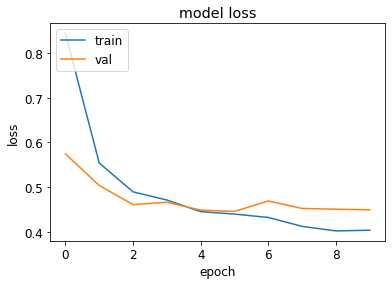

In [ ]:
# Plot history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

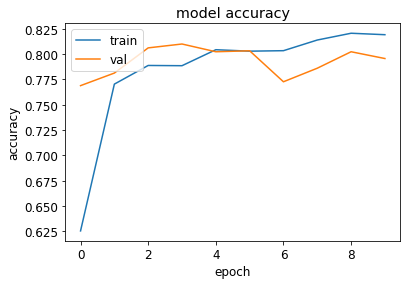

In [ ]:
#Plot history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
y_3pred = model.predict(x_3test)
y_3pred = np.argmax(y_3pred, axis=1)

y_3true = np.argmax(onehot_y_3test, axis=1)

In [ ]:
print(classification_report(y_3true, y_3pred, target_names = ['normal', 'bacterial_pneumonia', 'viral_pneumonia']))

                     precision    recall  f1-score   support

             normal       0.69      0.99      0.81       242
bacterial_pneumonia       0.98      0.50      0.66       234
    viral_pneumonia       0.56      0.59      0.58       148

           accuracy                           0.71       624
          macro avg       0.74      0.69      0.68       624
       weighted avg       0.77      0.71      0.70       624



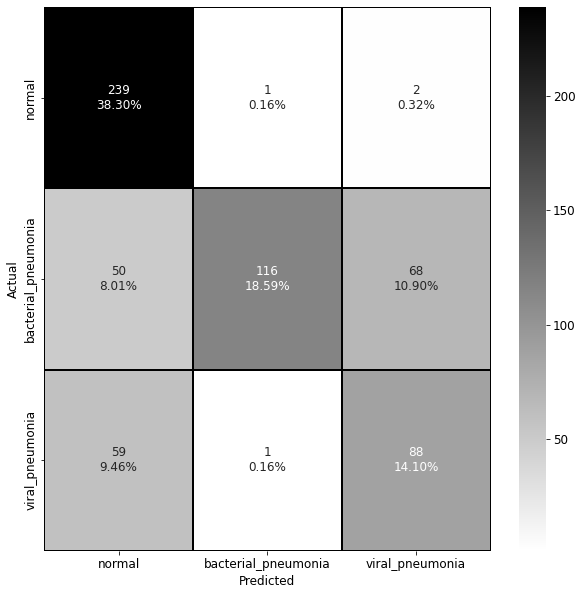

In [ ]:
cm = confusion_matrix(y_3true, y_3pred)
names = ['normal', 'bacterial_pneumonia', 'viral_pneumonia']

cm = pd.DataFrame(cm, index = names , columns = names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize = (10,10))
sns.heatmap(cm,
            annot=labels,
            cmap= "binary",
            linecolor = 'black',
            linewidth = 1,
            fmt='')

## **Part 3 : Try to improve CNN model with 3 classes**

## Building CNN model :

In [ ]:
# Define input shape
input_shape = (224, 224, 3)
num_classes = 3

In [ ]:
#Define architecture of model
input_model = layers.Input(shape=input_shape)
conv_1 = layers.Conv2D(32, kernel_size=(3,3), activation="relu", strides=(1,1), padding="same")(input_model)
#batch_norm_1 = BatchNormalization()(conv_1)
max_pool_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_1)
#batch_norm_2 = BatchNormalization()(max_pool_1)
conv_2 = layers.Conv2D(64, kernel_size=(3,3), activation="relu", strides=(1,1), padding="same")(max_pool_1)
#batch_norm_3 = BatchNormalization()(conv_2)
max_pool_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_2)
#batch_norm_4 = BatchNormalization()(max_pool_2)
conv_3 = layers.Conv2D(128, kernel_size=(3,3), activation="relu", strides=(1,1), padding="same")(max_pool_2)
#batch_norm_5 = BatchNormalization()(conv_3)
max_pool_3 = layers.MaxPooling2D(pool_size=(2,2))(conv_3)
#batch_norm_6 = BatchNormalization()(max_pool_3)
flatten_1 = layers.Flatten()(max_pool_3)
dense_1 = layers.Dense(128, activation="relu")(flatten_1)
#batch_norm_7 = BatchNormalization()(dense_1)
drop_out_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(64, activation="relu")(drop_out_1)
drop_out_2 = layers.Dropout(0.2)(dense_2)
output = layers.Dense(num_classes, activation="softmax")(drop_out_2)
                                 
model = keras.Model(inputs=input_model, outputs=output)

In [ ]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 128)       0   

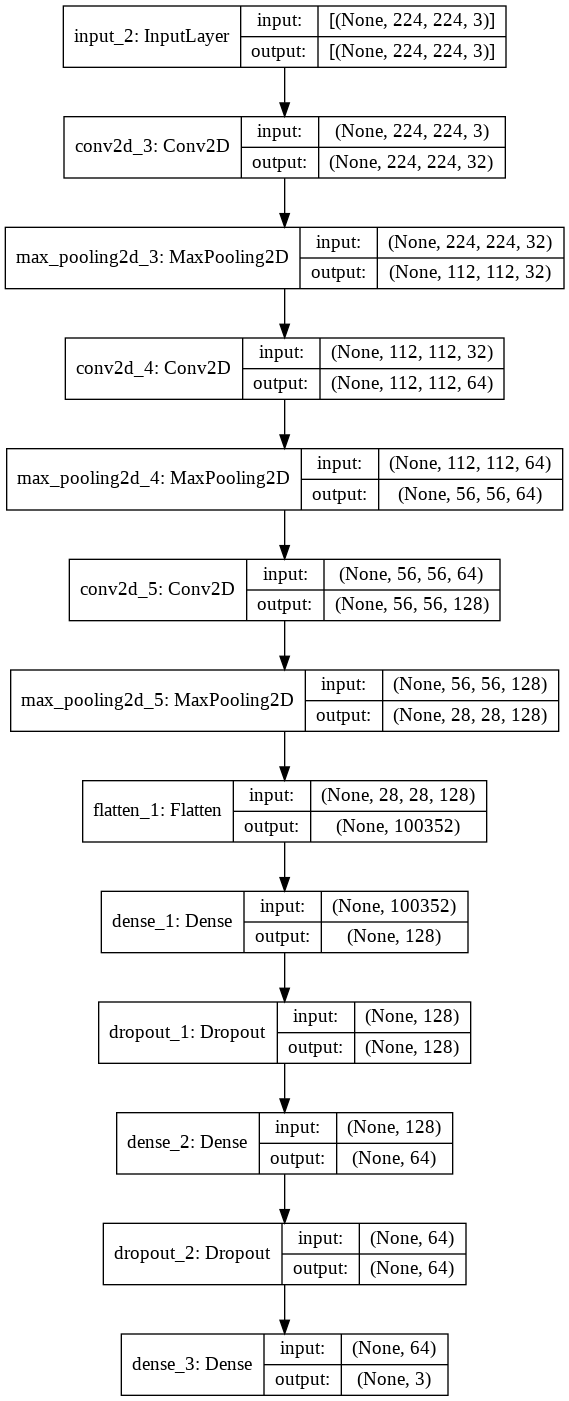

In [ ]:
keras.utils.plot_model(model, "CNN_chestXray.png", show_shapes=True)

## Training CNN model

In [ ]:
batch_size = 32
epochs = 30
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(x_3train, onehot_y_3train, batch_size=batch_size, epochs=epochs, validation_data=(x_3val, onehot_y_3val), callbacks=[callback])

Epoch 1/30
131/131 [==============================] - 17s 120ms/step - loss: 0.8033 - accuracy: 0.6284 - val_loss: 0.5234 - val_accuracy: 0.7813
Epoch 2/30
131/131 [==============================] - 14s 104ms/step - loss: 0.5617 - accuracy: 0.7613 - val_loss: 0.4965 - val_accuracy: 0.8080
Epoch 3/30
131/131 [==============================] - 14s 105ms/step - loss: 0.5126 - accuracy: 0.7795 - val_loss: 0.4556 - val_accuracy: 0.8138
Epoch 4/30
131/131 [==============================] - 14s 105ms/step - loss: 0.4801 - accuracy: 0.7871 - val_loss: 0.4874 - val_accuracy: 0.7822
Epoch 5/30
131/131 [==============================] - 14s 106ms/step - loss: 0.4740 - accuracy: 0.7993 - val_loss: 0.4591 - val_accuracy: 0.7908
Epoch 6/30
131/131 [==============================] - 14s 106ms/step - loss: 0.4481 - accuracy: 0.8014 - val_loss: 0.4406 - val_accuracy: 0.7985
Epoch 7/30
131/131 [==============================] - 14s 106ms/step - loss: 0.4316 - accuracy: 0.8127 - val_loss: 0.4367 - val_ac

## Evaluating CNN model

In [ ]:
#Evaluate model with test data
_, acc = model.evaluate(x_3test, onehot_y_3test, verbose=1)
print("Accuracy = " '%.3f' % (acc * 100.0))

20/20 [==============================] - 1s 54ms/step - loss: 0.8928 - accuracy: 0.7548
Accuracy = 75.481


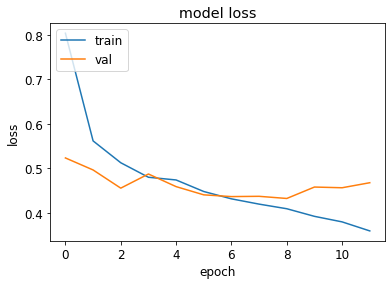

In [ ]:
#Plot history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

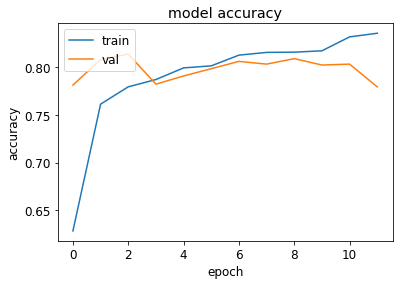

In [ ]:
#Plot history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
y_3pred = model.predict(x_3test)
y_3pred = np.argmax(y_3pred, axis=1)

y_3true = np.argmax(onehot_y_3test, axis=1)

In [ ]:
print(classification_report(y_3true, y_3pred, target_names = ['normal', 'bacterial_pneumonia', 'viral_pneumonia']))

                     precision    recall  f1-score   support

             normal       0.81      0.95      0.88       242
bacterial_pneumonia       0.98      0.52      0.68       234
    viral_pneumonia       0.55      0.80      0.65       148

           accuracy                           0.75       624
          macro avg       0.78      0.76      0.74       624
       weighted avg       0.81      0.75      0.75       624



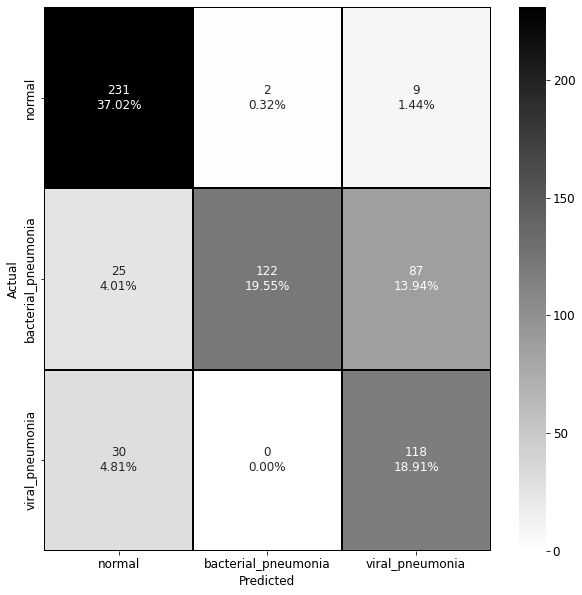

In [ ]:
cm = confusion_matrix(y_3true, y_3pred)
names = ['normal', 'bacterial_pneumonia', 'viral_pneumonia']

cm = pd.DataFrame(cm, index = names , columns = names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize = (10,10))
sns.heatmap(cm,
            annot=labels,
            cmap= "binary",
            linecolor = 'black',
            linewidth = 1,
            fmt='')

## **Part 4 : Transfer learning**

In [ ]:
input_shape = (224, 224, 3)
num_classes = 3
input=layers.Input(shape = (224, 224, 3))

base_model = InceptionV3(include_top=False, input_shape = input_shape, weights = "imagenet")
base_model.trainable = False

pre_trained = base_model(input)
flatten = layers.Flatten() (pre_trained)
dense_1 = layers.Dense(128, activation="relu")(flatten)
drop_out_1 = layers.Dropout(0.2)(dense_1)
output = layers.Dense(num_classes, activation="softmax")(drop_out_1)

model = keras.Model(inputs=input, outputs=output)

87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 28,356,899
Trainable params: 6,554,115
Non-trainable params: 21,802,784
_______________________________________

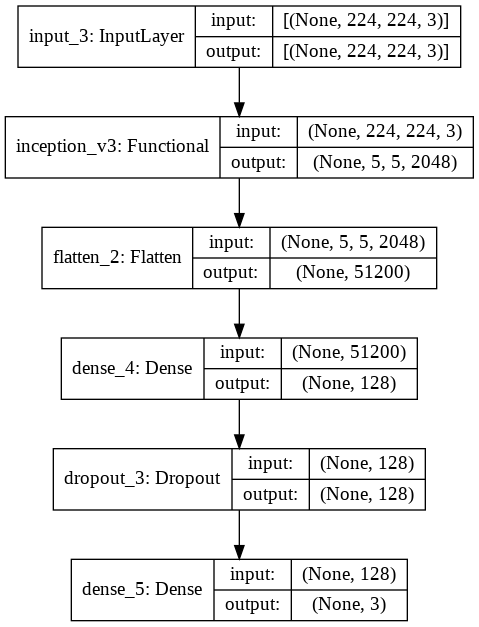

In [ ]:
keras.utils.plot_model(model, "CNN_chestXray.png", show_shapes=True)

In [ ]:
batch_size = 32
epochs = 30
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(x_3train, onehot_y_3train, batch_size=batch_size, epochs=epochs, validation_data=(x_3val, onehot_y_3val), callbacks=[callback])

Epoch 1/30
131/131 [==============================] - 39s 247ms/step - loss: 0.8470 - accuracy: 0.6643 - val_loss: 0.5426 - val_accuracy: 0.7794
Epoch 2/30
131/131 [==============================] - 27s 207ms/step - loss: 0.5456 - accuracy: 0.7579 - val_loss: 0.4953 - val_accuracy: 0.7660
Epoch 3/30
131/131 [==============================] - 27s 206ms/step - loss: 0.4907 - accuracy: 0.7740 - val_loss: 0.5020 - val_accuracy: 0.7765
Epoch 4/30
131/131 [==============================] - 27s 208ms/step - loss: 0.4519 - accuracy: 0.8108 - val_loss: 0.4682 - val_accuracy: 0.7889
Epoch 5/30
131/131 [==============================] - 27s 209ms/step - loss: 0.4165 - accuracy: 0.8179 - val_loss: 0.4624 - val_accuracy: 0.7947
Epoch 6/30
131/131 [==============================] - 27s 209ms/step - loss: 0.3763 - accuracy: 0.8344 - val_loss: 0.4373 - val_accuracy: 0.8071
Epoch 7/30
131/131 [==============================] - 27s 209ms/step - loss: 0.3587 - accuracy: 0.8449 - val_loss: 0.5281 - val_ac

In [ ]:
#Evaluate model with test data
_, acc = model.evaluate(x_3test, onehot_y_3test, verbose=1)
print("Accuracy = " '%.3f' % (acc * 100.0))

20/20 [==============================] - 5s 235ms/step - loss: 0.5362 - accuracy: 0.8221
Accuracy = 82.212


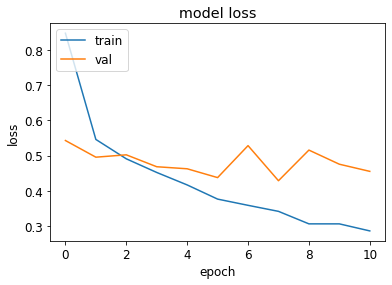

In [ ]:
#Plot history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

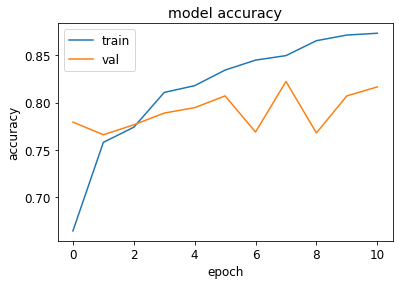

In [ ]:
#Plot history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
y_3pred = model.predict(x_3test)
y_3pred = np.argmax(y_3pred, axis=1)

y_3true = np.argmax(onehot_y_3test, axis=1)

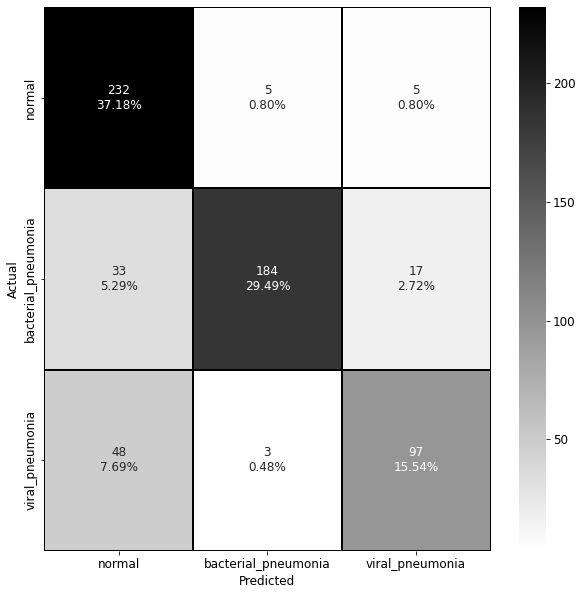

In [ ]:
cm = confusion_matrix(y_3true, y_3pred)
names = ['normal', 'bacterial_pneumonia', 'viral_pneumonia']

cm = pd.DataFrame(cm, index = names , columns = names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize = (10,10))
sns.heatmap(cm,
            annot=labels,
            cmap= "binary",
            linecolor = 'black',
            linewidth = 1,
            fmt='')

## Transfert learning with 2 classes

In [ ]:
# Conversing images in pixel matrix in aray
x_2train = [img_to_array(image) for image in img_data_train_normal]
x_2train.extend([img_to_array(image) for image in img_data_train_bacterial_pneumonia])
x_2train.extend([img_to_array(image) for image in img_data_train_viral_pneumonia])
x_2train = np.asarray(x_2train)

x_2val = [img_to_array(image) for image in img_data_val_normal]
x_2val.extend([img_to_array(image) for image in img_data_val_bacterial_pneumonia])
x_2val.extend([img_to_array(image) for image in img_data_val_viral_pneumonia])
x_2val = np.asarray(x_2val)

x_2test = [img_to_array(image) for image in img_data_test_normal]
x_2test.extend([img_to_array(image) for image in img_data_test_bacterial_pneumonia])
x_2test.extend([img_to_array(image) for image in img_data_test_viral_pneumonia])
x_2test = np.asarray(x_2test)

In [ ]:
# Creating label matrix "normal" or "pneumonia"
y_2train = ["normal" for image in img_data_train_normal]
y_2train.extend(["pneumonia" for image in img_data_train_bacterial_pneumonia])
y_2train.extend(["pneumonia" for image in img_data_train_viral_pneumonia])
y_2train = np.asarray(y_2train)

y_2val = ["normal" for image in img_data_val_normal]
y_2val.extend(["pneumonia" for image in img_data_val_bacterial_pneumonia])
y_2val.extend(["pneumonia" for image in img_data_val_viral_pneumonia])
y_2val = np.asarray(y_2val)

y_2test = ["normal" for image in img_data_test_normal]
y_2test.extend(["pneumonia" for image in img_data_test_bacterial_pneumonia])
y_2test.extend(["pneumonia" for image in img_data_test_viral_pneumonia])
y_2test = np.asarray(y_2test)

In [ ]:
# Scaling images to the [0, 1] range in 32 bits
x_2train = x_2train.astype("float32") / 255
x_2val = x_2val.astype("float32") / 255
x_2test = x_2test.astype("float32") / 255

In [ ]:
# Converting class vector for train data
classes_2train = preprocessing.LabelEncoder()
classes_2train.fit(y_2train)
classes_2train = classes_2train.transform(y_2train)
onehot_y_2train = keras.utils.to_categorical(classes_2train, 2)

In [ ]:
# Converting class vector for validation data
classes_2val = preprocessing.LabelEncoder()
classes_2val.fit(y_2val)
classes_2val = classes_2val.transform(y_2val)
onehot_y_2val = keras.utils.to_categorical(classes_2val, 2)

In [ ]:
#Converting class vector for test data
classes_2test = preprocessing.LabelEncoder()
classes_2test.fit(y_2test)
classes_2test = classes_2test.transform(y_2test)
onehot_y_2test = keras.utils.to_categorical(classes_2test, 2)

In [ ]:
input_shape = (224, 224, 3)
num_classes = 2
input=layers.Input(shape = (224, 224, 3))

base_model = InceptionV3(include_top=False, input_shape = input_shape, weights = "imagenet")
base_model.trainable = False

pre_trained = base_model(input)
flatten = layers.Flatten() (pre_trained)
dense_1 = layers.Dense(128, activation="relu")(flatten)
drop_out_1 = layers.Dropout(0.2)(dense_1)
output = layers.Dense(num_classes, activation="softmax")(drop_out_1)

model = keras.Model(inputs=input, outputs=output)

In [ ]:
batch_size = 32
epochs = 30
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
history = model.fit(x_2train, onehot_y_2train, batch_size=batch_size, epochs=epochs, validation_data=(x_2val, onehot_y_2val), callbacks=[callback])

Epoch 1/30
131/131 [==============================] - 66s 244ms/step - loss: 0.3511 - accuracy: 0.9023 - val_loss: 0.0984 - val_accuracy: 0.9608
Epoch 2/30
131/131 [==============================] - 27s 206ms/step - loss: 0.0936 - accuracy: 0.9642 - val_loss: 0.1060 - val_accuracy: 0.9570
Epoch 3/30
131/131 [==============================] - 27s 208ms/step - loss: 0.0793 - accuracy: 0.9680 - val_loss: 0.0751 - val_accuracy: 0.9723
Epoch 4/30
131/131 [==============================] - 27s 209ms/step - loss: 0.0528 - accuracy: 0.9821 - val_loss: 0.0745 - val_accuracy: 0.9685
Epoch 5/30
131/131 [==============================] - 27s 209ms/step - loss: 0.0309 - accuracy: 0.9895 - val_loss: 0.0814 - val_accuracy: 0.9761
Epoch 6/30
131/131 [==============================] - 27s 208ms/step - loss: 0.0314 - accuracy: 0.9897 - val_loss: 0.0816 - val_accuracy: 0.9704
Epoch 7/30
131/131 [==============================] - 27s 209ms/step - loss: 0.0236 - accuracy: 0.9931 - val_loss: 0.0724 - val_ac

In [ ]:
#Evaluate model with test data
_, acc = model.evaluate(x_2test, onehot_y_2test, verbose=1)
print("Accuracy = " '%.3f' % (acc * 100.0))

20/20 [==============================] - 5s 232ms/step - loss: 0.5917 - accuracy: 0.8590
Accuracy = 85.897


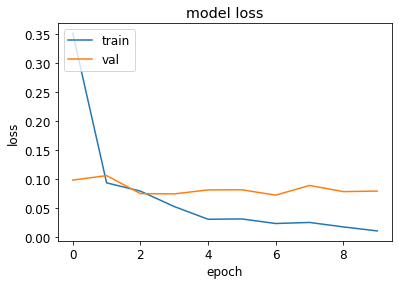

In [ ]:
#Plot history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

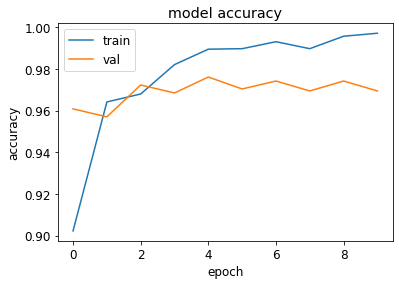

In [ ]:
#Plot history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()